In [ ]:
! pip uninstall -y kaggle
! pip install -q kaggle==1.5.6
! pip install --upgrade kaggle

Uninstalling kaggle-1.5.8:
  Successfully uninstalled kaggle-1.5.8
     |████████████████████████████████| 61kB 4.6MB/s 
     |████████████████████████████████| 61kB 4.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.8-cp36-none-any.whl size=73275 sha256=04c45d064900fad53084bc4e1e4af16ae85afc10752ba6d72c4a102a8b94be2f
  Stored in directory: /root/.cache/pip/wheels/94/a7/09/68dc83c7c14fdbdf5d3f2b2da5b87e587bfc1e85df69b1130c
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"naadaa","key":"ed7ea56ee5a1947967d7852aeae6019e"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c plant-seedlings-classification

100% 1.68G/1.69G [00:28<00:00, 65.3MB/s]
100% 1.69G/1.69G [00:28<00:00, 64.6MB/s]


In [ ]:
! unzip plant-seedlings-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/adb7a032c.png      
  inflating: test/ae90f2827.png      
  inflating: test/aecfaed64.png      
  inflating: test/aee6fa3df.png      
  inflating: test/af45e222a.png      
  inflating: test/afa446484.png      
  inflating: test/afcf6abd5.png      
  inflating: test/b026bf8ca.png      
  inflating: test/b03397525.png      
  inflating: test/b0acaff4a.png      
  inflating: test/b130a0632.png      
  inflating: test/b145ba9d4.png      
  inflating: test/b1cd2a91e.png      
  inflating: test/b215531dd.png      
  inflating: test/b2706e2b3.png      
  inflating: test/b29339405.png      
  inflating: test/b30ab4659.png      
  inflating: test/b31292706.png      
  inflating: test/b341d0aab.png      
  inflating: test/b39c71707.png      
  inflating: test/b3d6fdb80.png      
  inflating: test/b3e08b037.png      
  inflating: test/b47691c08.png      
  inflating: test/b4c3df835.png      
  inflating: test/b4f7c9214.png      

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as img 
import glob
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image
from distutils.dir_util import copy_tree
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
import tempfile
from keras.preprocessing import image
import time


In [ ]:
! pip install -q tensorflow-model-optimization


     |████████████████████████████████| 174kB 7.5MB/s 


In [ ]:
os. getcwd()

'/content'

In [ ]:
os. listdir('/content')   

['.config',
 'kaggle.json',
 'test',
 'train',
 'plant-seedlings-classification.zip',
 'sample_submission.csv',
 'sample_data']

In [ ]:
class_dict={}
class_list=[]
for name in glob.glob('/content/train/*'): 
    class_dict[name[len('/content/train/'):]]=0
    class_list.append(name[len('/content/train/'):])

In [ ]:
print("Total number of classes: ",len(class_list),'\n')
total_examples=0
for i in class_list: 
    class_dict[i]=len(os.listdir('/content/train/'+str(i)))
    total_examples+=len(os.listdir('/content/train/'+str(i)))
    
print('total images: ',total_examples)
class_dict 

Total number of classes:  12 

total images:  4750


{'Black-grass': 263,
 'Charlock': 390,
 'Cleavers': 287,
 'Common Chickweed': 611,
 'Common wheat': 221,
 'Fat Hen': 475,
 'Loose Silky-bent': 654,
 'Maize': 221,
 'Scentless Mayweed': 516,
 'Shepherds Purse': 231,
 'Small-flowered Cranesbill': 496,
 'Sugar beet': 385}

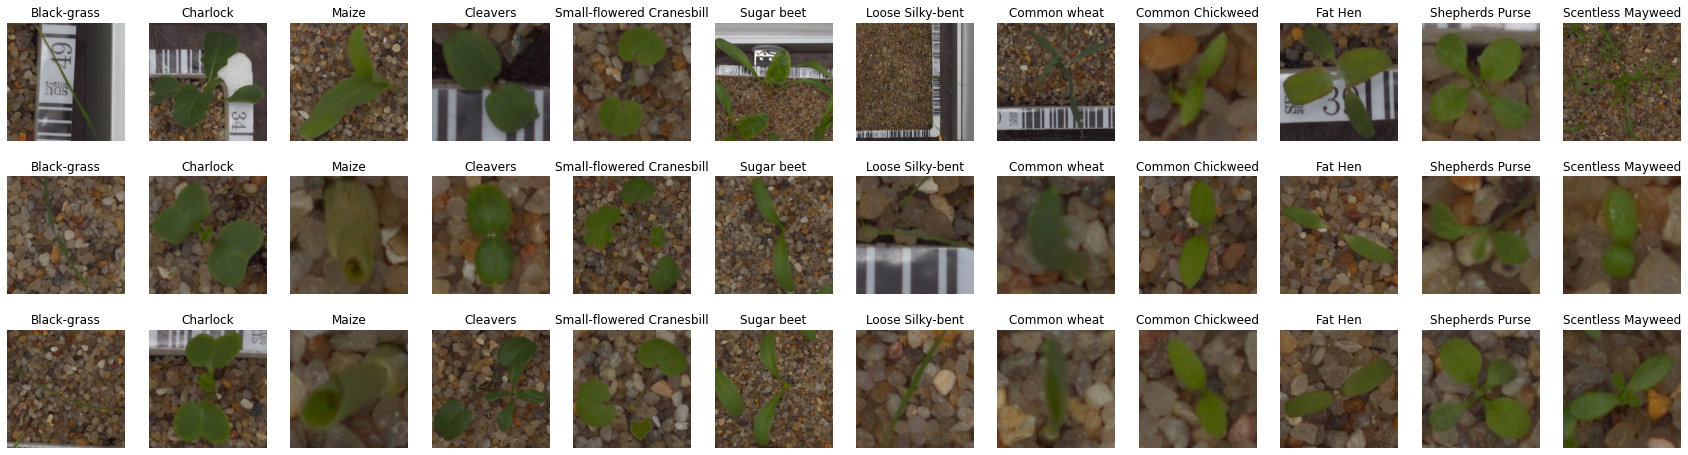

In [ ]:
fig,image =  plt.subplots(3,12,squeeze=False,figsize=(30,8))
for j in range(12):
    ls = os.listdir('/content/train/'+str(class_list[j]))
    for i in range(0,3):
        a=img.imread('/content/train/'+str(class_list[j])+'/'+ls[3*i])
        image[i][j].imshow(a)
        image[i][j].axis("off")
        image[i][j].set_title(class_list[j])

**Deviding data into train and validation set**


In [ ]:
batch_size = 100
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4750 files belonging to 12 classes.
Using 3800 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/train',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4750 files belonging to 12 classes.
Using 950 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']




# **VGG 16**

In [ ]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [ ]:
IMG_SHAPE = (img_height, img_width) + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(12, activation='softmax')

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/VGG16', monitor='val_loss', verbose=1,save_best_only=True, save_weights_only=False, mode='auto', save_frequency=1)


inputs  = tf.keras.Input(shape=(180, 180, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
history = model.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds,
                    callbacks=[checkpoint])
                   

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 3.9226 - accuracy: 0.1968
Epoch 00001: val_loss improved from inf to 2.27797, saving model to /content/VGG16
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/VGG16/assets
38/38 [==============================] - 57s 1s/step - loss: 3.9226 - accuracy: 0.1968 - val_loss: 2.2780 - val_accuracy: 0.3453
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 2.2295 - accuracy: 0.3587
Epoch 00002: val_loss improved from 2.27797 to 1.64863, saving model to /content/VGG16
INFO:tensorflow:Assets written to: /content/VGG16/assets
38/38 [==============================] - 55s 1s/step - loss: 2.2295 - accuracy: 0.3587 - val_loss: 1.6486 - val_accuracy: 0.4811
Epoch 3/20
38/38 [==================

In [ ]:
tf.keras.models.save_model(model, '/content/baseline_VGG16.h5', include_optimizer=False)
#print('Saved baseline model to:', keras_file)

## Model Optimization Using TF-Lite(Post Training Dynamic range quantization) VGG


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpdft3yzet/assets


In [ ]:
import pathlib
tflite_models_dir = pathlib.Path("/tmp/VGG_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
tflite_model_file = tflite_models_dir/"VGG_model.tflite"
tflite_model_file.write_bytes(tflite_model)

58894056

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"VGG_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpolo3nxoh/assets


INFO:tensorflow:Assets written to: /tmp/tmpolo3nxoh/assets


14745216

In [ ]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [ ]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

In [ ]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
pre = []
labels=[]
for image_batch , label_batch in val_ds.as_numpy_iterator():
  for item in range(len(image_batch)):
    image_batch_i = np.expand_dims(image_batch[item], axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, image_batch_i)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)
    pre.append(np.argmax(predictions))
    labels.append(label_batch[item])  

In [ ]:
from sklearn.metrics import accuracy_score
print('dynamic quantization model accuracy: ')
print(accuracy_score(labels, pre))

dynamic quantization model accuracy: 
0.7726315789473684


 ## Optimization of VGG Model with TensorRT

In [ ]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
model.save('vgg_saved_model')

INFO:tensorflow:Assets written to: vgg_saved_model/assets


INFO:tensorflow:Assets written to: vgg_saved_model/assets


TF-TRT FP32 model


In [ ]:
print('Converting to TF-TRT FP32...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP32,
                                                               max_workspace_size_bytes=8000000000)

converter = trt.TrtGraphConverterV2(input_saved_model_dir='vgg_saved_model',
                                    conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='vgg_saved_model_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

Converting to TF-TRT FP32...
INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Assets written to: vgg_saved_model_TFTRT_FP32/assets


INFO:tensorflow:Assets written to: vgg_saved_model_TFTRT_FP32/assets


Done Converting to TF-TRT FP32


In [ ]:
batch_size = 8
batched_input = np.zeros((batch_size, 128, 128, 3), dtype=np.float32)

for i in range(batch_size):
    img_path = '/content/train/Common Chickweed'
    for j in os.listdir(img_path):
        img = image.load_img(os.path.join(img_path,j), target_size=(128, 128))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (8, 128, 128, 3)


In [ ]:
from tensorflow.python.saved_model import tag_constants

def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 500
    elapsed_time = []

    for i in range(N_warmup_run):
        labeling = infer(batched_input)

    for i in range(N_run):
        start_time = time.time()
        labeling = infer(batched_input)
        #prob = labeling['probs'].numpy()
        end_time = time.time()
        elapsed_time = np.append(elapsed_time, end_time - start_time)
        if i % 50 == 0:
            print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

In [ ]:
benchmark_tftrt('vgg_saved_model_TFTRT_FP32')

Step 0: 18.7ms
Step 50: 16.3ms
Step 100: 16.6ms
Step 150: 16.6ms
Step 200: 16.7ms
Step 250: 16.7ms
Step 300: 16.6ms
Step 350: 16.8ms
Step 400: 16.7ms
Step 450: 16.9ms
Throughput: 480 images/s


TF-TRT FP16 model


In [ ]:
print('Converting to TF-TRT FP16...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.FP16,
    max_workspace_size_bytes=8000000000)
converter = trt.TrtGraphConverterV2(
   input_saved_model_dir='vgg_saved_model', conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='vgg_saved_model_TFTRT_FP16')
print('Done Converting to TF-TRT FP16')

Converting to TF-TRT FP16...
INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Assets written to: vgg_saved_model_TFTRT_FP16/assets


INFO:tensorflow:Assets written to: vgg_saved_model_TFTRT_FP16/assets


Done Converting to TF-TRT FP16


In [ ]:
benchmark_tftrt('vgg_saved_model_TFTRT_FP16')


Step 0: 16.2ms
Step 50: 16.4ms
Step 100: 16.4ms
Step 150: 16.3ms
Step 200: 16.2ms
Step 250: 16.2ms
Step 300: 16.3ms
Step 350: 16.4ms
Step 400: 16.3ms
Step 450: 16.2ms
Throughput: 491 images/s


TF-TRT INT8 model (with calibration)

In [ ]:
print('Converting to TF-TRT INT8...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.INT8, 
    max_workspace_size_bytes=8000000000, 
    use_calibration=True)
converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='vgg_saved_model', 
    conversion_params=conversion_params)

def calibration_input_fn():
    yield (batched_input, )
converter.convert(calibration_input_fn=calibration_input_fn)

converter.save(output_saved_model_dir='vgg_saved_model_TFTRT_INT8')
print('Done Converting to TF-TRT INT8')

Converting to TF-TRT INT8...
INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Assets written to: vgg_saved_model_TFTRT_INT8/assets


INFO:tensorflow:Assets written to: vgg_saved_model_TFTRT_INT8/assets


Done Converting to TF-TRT INT8


In [ ]:
benchmark_tftrt('vgg_saved_model_TFTRT_INT8')


Step 0: 15.5ms
Step 50: 16.0ms
Step 100: 16.0ms
Step 150: 15.9ms
Step 200: 15.9ms
Step 250: 16.0ms
Step 300: 16.0ms
Step 350: 16.0ms
Step 400: 16.0ms
Step 450: 16.0ms
Throughput: 501 images/s


# Inception

In [ ]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [ ]:
IMG_SHAPE = (img_height, img_width) + (3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 89, 89, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 89, 89, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 89, 89, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(12, activation='softmax')

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/Inception', monitor='val_loss', verbose=1,save_best_only=True, save_weights_only=False, mode='auto', save_frequency=1)


inputs  = tf.keras.Input(shape=(180, 180, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
history = model.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds,
                    callbacks=[checkpoint])
                    

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 1.9111 - accuracy: 0.3708
Epoch 00001: val_loss improved from inf to 1.39669, saving model to /content/Inception
INFO:tensorflow:Assets written to: /content/Inception/assets


INFO:tensorflow:Assets written to: /content/Inception/assets


38/38 [==============================] - 80s 2s/step - loss: 1.9111 - accuracy: 0.3708 - val_loss: 1.3967 - val_accuracy: 0.5832
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 1.1796 - accuracy: 0.6287
Epoch 00002: val_loss improved from 1.39669 to 1.09063, saving model to /content/Inception
INFO:tensorflow:Assets written to: /content/Inception/assets


INFO:tensorflow:Assets written to: /content/Inception/assets


38/38 [==============================] - 79s 2s/step - loss: 1.1796 - accuracy: 0.6287 - val_loss: 1.0906 - val_accuracy: 0.6800
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.9586 - accuracy: 0.7000
Epoch 00003: val_loss improved from 1.09063 to 0.97949, saving model to /content/Inception
INFO:tensorflow:Assets written to: /content/Inception/assets


INFO:tensorflow:Assets written to: /content/Inception/assets


38/38 [==============================] - 79s 2s/step - loss: 0.9586 - accuracy: 0.7000 - val_loss: 0.9795 - val_accuracy: 0.7032
Epoch 4/20
38/38 [==============================] - ETA: 0s - loss: 0.8150 - accuracy: 0.7584
Epoch 00004: val_loss improved from 0.97949 to 0.88600, saving model to /content/Inception
INFO:tensorflow:Assets written to: /content/Inception/assets


INFO:tensorflow:Assets written to: /content/Inception/assets


38/38 [==============================] - 79s 2s/step - loss: 0.8150 - accuracy: 0.7584 - val_loss: 0.8860 - val_accuracy: 0.7242
Epoch 5/20
38/38 [==============================] - ETA: 0s - loss: 0.7382 - accuracy: 0.7708
Epoch 00005: val_loss improved from 0.88600 to 0.82698, saving model to /content/Inception
INFO:tensorflow:Assets written to: /content/Inception/assets


INFO:tensorflow:Assets written to: /content/Inception/assets


38/38 [==============================] - 80s 2s/step - loss: 0.7382 - accuracy: 0.7708 - val_loss: 0.8270 - val_accuracy: 0.7474
Epoch 6/20
38/38 [==============================] - ETA: 0s - loss: 0.6495 - accuracy: 0.8118
Epoch 00006: val_loss improved from 0.82698 to 0.79216, saving model to /content/Inception
INFO:tensorflow:Assets written to: /content/Inception/assets


INFO:tensorflow:Assets written to: /content/Inception/assets


38/38 [==============================] - 79s 2s/step - loss: 0.6495 - accuracy: 0.8118 - val_loss: 0.7922 - val_accuracy: 0.7579
Epoch 7/20
38/38 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.8295
Epoch 00007: val_loss improved from 0.79216 to 0.76691, saving model to /content/Inception
INFO:tensorflow:Assets written to: /content/Inception/assets


INFO:tensorflow:Assets written to: /content/Inception/assets


38/38 [==============================] - 80s 2s/step - loss: 0.5901 - accuracy: 0.8295 - val_loss: 0.7669 - val_accuracy: 0.7653
Epoch 8/20
38/38 [==============================] - ETA: 0s - loss: 0.5469 - accuracy: 0.8408
Epoch 00008: val_loss improved from 0.76691 to 0.75313, saving model to /content/Inception
INFO:tensorflow:Assets written to: /content/Inception/assets


INFO:tensorflow:Assets written to: /content/Inception/assets


38/38 [==============================] - 79s 2s/step - loss: 0.5469 - accuracy: 0.8408 - val_loss: 0.7531 - val_accuracy: 0.7716
Epoch 9/20
38/38 [==============================] - ETA: 0s - loss: 0.5226 - accuracy: 0.8468
Epoch 00009: val_loss improved from 0.75313 to 0.71651, saving model to /content/Inception
INFO:tensorflow:Assets written to: /content/Inception/assets


INFO:tensorflow:Assets written to: /content/Inception/assets


38/38 [==============================] - 80s 2s/step - loss: 0.5226 - accuracy: 0.8468 - val_loss: 0.7165 - val_accuracy: 0.7768
Epoch 10/20
38/38 [==============================] - ETA: 0s - loss: 0.4833 - accuracy: 0.8647
Epoch 00010: val_loss improved from 0.71651 to 0.70830, saving model to /content/Inception
INFO:tensorflow:Assets written to: /content/Inception/assets


INFO:tensorflow:Assets written to: /content/Inception/assets


38/38 [==============================] - 80s 2s/step - loss: 0.4833 - accuracy: 0.8647 - val_loss: 0.7083 - val_accuracy: 0.7821
Epoch 11/20
38/38 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.8737
Epoch 00011: val_loss did not improve from 0.70830
38/38 [==============================] - 45s 1s/step - loss: 0.4599 - accuracy: 0.8737 - val_loss: 0.7093 - val_accuracy: 0.7684
Epoch 12/20
38/38 [==============================] - ETA: 0s - loss: 0.4255 - accuracy: 0.8795
Epoch 00012: val_loss improved from 0.70830 to 0.70200, saving model to /content/Inception
INFO:tensorflow:Assets written to: /content/Inception/assets


INFO:tensorflow:Assets written to: /content/Inception/assets


38/38 [==============================] - 79s 2s/step - loss: 0.4255 - accuracy: 0.8795 - val_loss: 0.7020 - val_accuracy: 0.7684
Epoch 13/20
38/38 [==============================] - ETA: 0s - loss: 0.4157 - accuracy: 0.8818
Epoch 00013: val_loss did not improve from 0.70200
38/38 [==============================] - 45s 1s/step - loss: 0.4157 - accuracy: 0.8818 - val_loss: 0.7169 - val_accuracy: 0.7737
Epoch 14/20
38/38 [==============================] - ETA: 0s - loss: 0.4055 - accuracy: 0.8861
Epoch 00014: val_loss improved from 0.70200 to 0.69367, saving model to /content/Inception
INFO:tensorflow:Assets written to: /content/Inception/assets


INFO:tensorflow:Assets written to: /content/Inception/assets


38/38 [==============================] - 80s 2s/step - loss: 0.4055 - accuracy: 0.8861 - val_loss: 0.6937 - val_accuracy: 0.7779
Epoch 15/20
38/38 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.8958
Epoch 00015: val_loss improved from 0.69367 to 0.67876, saving model to /content/Inception
INFO:tensorflow:Assets written to: /content/Inception/assets


INFO:tensorflow:Assets written to: /content/Inception/assets


38/38 [==============================] - 80s 2s/step - loss: 0.3743 - accuracy: 0.8958 - val_loss: 0.6788 - val_accuracy: 0.7832
Epoch 16/20
38/38 [==============================] - ETA: 0s - loss: 0.3576 - accuracy: 0.9039
Epoch 00016: val_loss did not improve from 0.67876
38/38 [==============================] - 45s 1s/step - loss: 0.3576 - accuracy: 0.9039 - val_loss: 0.6893 - val_accuracy: 0.7758
Epoch 17/20
38/38 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.9008
Epoch 00017: val_loss did not improve from 0.67876
38/38 [==============================] - 45s 1s/step - loss: 0.3573 - accuracy: 0.9008 - val_loss: 0.6806 - val_accuracy: 0.7821
Epoch 18/20
38/38 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.9055
Epoch 00018: val_loss improved from 0.67876 to 0.67169, saving model to /content/Inception
INFO:tensorflow:Assets written to: /content/Inception/assets


INFO:tensorflow:Assets written to: /content/Inception/assets


38/38 [==============================] - 79s 2s/step - loss: 0.3342 - accuracy: 0.9055 - val_loss: 0.6717 - val_accuracy: 0.7789
Epoch 19/20
38/38 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.9137
Epoch 00019: val_loss improved from 0.67169 to 0.65800, saving model to /content/Inception
INFO:tensorflow:Assets written to: /content/Inception/assets


INFO:tensorflow:Assets written to: /content/Inception/assets


38/38 [==============================] - 80s 2s/step - loss: 0.3299 - accuracy: 0.9137 - val_loss: 0.6580 - val_accuracy: 0.7947
Epoch 20/20
38/38 [==============================] - ETA: 0s - loss: 0.3163 - accuracy: 0.9176
Epoch 00020: val_loss did not improve from 0.65800
38/38 [==============================] - 46s 1s/step - loss: 0.3163 - accuracy: 0.9176 - val_loss: 0.6625 - val_accuracy: 0.7905


## Model Optimization Using TF-Lite(Post Training Dynamic range quantization) Inception

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpkmv1825g/assets


INFO:tensorflow:Assets written to: /tmp/tmpkmv1825g/assets


In [ ]:
import pathlib
tflite_models_dir = pathlib.Path("/tmp/inception_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
tflite_model_file = tflite_models_dir/"inception_model.tflite"
tflite_model_file.write_bytes(tflite_model)

87232780

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"inception_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)


INFO:tensorflow:Assets written to: /tmp/tmp8o3h0ioq/assets


INFO:tensorflow:Assets written to: /tmp/tmp8o3h0ioq/assets


21914416

In [ ]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [ ]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

In [ ]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
pre = []
labels=[]
for image_batch , label_batch in val_ds.as_numpy_iterator():
  for item in range(len(image_batch)):
    image_batch_i = np.expand_dims(image_batch[item], axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, image_batch_i)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)
    pre.append(np.argmax(predictions))
    labels.append(label_batch[item]) 

In [ ]:
from sklearn.metrics import accuracy_score
print('dynamic quantization model accuracy: ')
print(accuracy_score(labels, pre))

dynamic quantization model accuracy: 
0.7905263157894736


 ## Optimization of Inception Model with TensorRT

In [ ]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
model.save('inception_saved_model')

INFO:tensorflow:Assets written to: inception_saved_model/assets


INFO:tensorflow:Assets written to: inception_saved_model/assets


TF-TRT FP32 model

In [ ]:
print('Converting to TF-TRT FP32...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP32,
                                                               max_workspace_size_bytes=8000000000)

converter = trt.TrtGraphConverterV2(input_saved_model_dir='inception_saved_model',
                                    conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='inception_saved_model_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

Converting to TF-TRT FP32...
INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Assets written to: inception_saved_model_TFTRT_FP32/assets


INFO:tensorflow:Assets written to: inception_saved_model_TFTRT_FP32/assets


Done Converting to TF-TRT FP32


In [ ]:
batch_size = 8
batched_input = np.zeros((batch_size, 128, 128, 3), dtype=np.float32)

for i in range(batch_size):
    img_path = '/content/train/Common Chickweed'
    for j in os.listdir(img_path):
        img = image.load_img(os.path.join(img_path,j), target_size=(128, 128))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (8, 128, 128, 3)


In [ ]:
from tensorflow.python.saved_model import tag_constants

def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 500
    elapsed_time = []

    for i in range(N_warmup_run):
        labeling = infer(batched_input)

    for i in range(N_run):
        start_time = time.time()
        labeling = infer(batched_input)
        #prob = labeling['probs'].numpy()
        end_time = time.time()
        elapsed_time = np.append(elapsed_time, end_time - start_time)
        if i % 50 == 0:
            print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))



In [ ]:
benchmark_tftrt('inception_saved_model_TFTRT_FP32')

Step 0: 11.7ms
Step 50: 11.9ms
Step 100: 11.7ms
Step 150: 12.0ms
Step 200: 11.9ms
Step 250: 11.9ms
Step 300: 11.8ms
Step 350: 11.8ms
Step 400: 11.9ms
Step 450: 11.9ms
Throughput: 673 images/s


TF-TRT FP16 model

In [ ]:
print('Converting to TF-TRT FP16...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.FP16,
    max_workspace_size_bytes=8000000000)
converter = trt.TrtGraphConverterV2(
   input_saved_model_dir='inception_saved_model', conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='inception_saved_model_TFTRT_FP16')
print('Done Converting to TF-TRT FP16')

Converting to TF-TRT FP16...
INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Assets written to: inception_saved_model_TFTRT_FP16/assets


INFO:tensorflow:Assets written to: inception_saved_model_TFTRT_FP16/assets


Done Converting to TF-TRT FP16


In [ ]:
benchmark_tftrt('inception_saved_model_TFTRT_FP16')

Step 0: 11.8ms
Step 50: 11.8ms
Step 100: 11.6ms
Step 150: 11.7ms
Step 200: 11.6ms
Step 250: 11.8ms
Step 300: 11.7ms
Step 350: 11.7ms
Step 400: 11.8ms
Step 450: 11.7ms
Throughput: 681 images/s


TF-TRT INT8 model (with calibration)

In [ ]:
print('Converting to TF-TRT INT8...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.INT8, 
    max_workspace_size_bytes=8000000000, 
    use_calibration=True)
converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='inception_saved_model', 
    conversion_params=conversion_params)

def calibration_input_fn():
    yield (batched_input, )
converter.convert(calibration_input_fn=calibration_input_fn)

converter.save(output_saved_model_dir='inception_saved_model_TFTRT_INT8')
print('Done Converting to TF-TRT INT8')

Converting to TF-TRT INT8...
INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Assets written to: inception_saved_model_TFTRT_INT8/assets


INFO:tensorflow:Assets written to: inception_saved_model_TFTRT_INT8/assets


Done Converting to TF-TRT INT8


In [ ]:
benchmark_tftrt('inception_saved_model_TFTRT_INT8')

Step 0: 11.8ms
Step 50: 11.8ms
Step 100: 11.8ms
Step 150: 11.8ms
Step 200: 11.8ms
Step 250: 11.9ms
Step 300: 11.8ms
Step 350: 11.8ms
Step 400: 11.9ms
Step 450: 11.8ms
Throughput: 676 images/s


# Resnet50

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [ ]:
IMG_SHAPE = (img_height, img_width) + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 186, 186, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 90, 90, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 90, 90, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(12, activation='softmax')

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/Resnet50', monitor='val_loss', verbose=1,save_best_only=True, save_weights_only=False, mode='auto', save_frequency=1)


inputs  = tf.keras.Input(shape=(180, 180, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
history = model.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds,
                    callbacks=[checkpoint])


Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 1.7862 - accuracy: 0.4084
Epoch 00001: val_loss improved from inf to 1.11794, saving model to /content/Resnet50
INFO:tensorflow:Assets written to: /content/Resnet50/assets


INFO:tensorflow:Assets written to: /content/Resnet50/assets


38/38 [==============================] - 75s 2s/step - loss: 1.7862 - accuracy: 0.4084 - val_loss: 1.1179 - val_accuracy: 0.6642
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.9564 - accuracy: 0.7018
Epoch 00002: val_loss improved from 1.11794 to 0.83811, saving model to /content/Resnet50
INFO:tensorflow:Assets written to: /content/Resnet50/assets


INFO:tensorflow:Assets written to: /content/Resnet50/assets


38/38 [==============================] - 71s 2s/step - loss: 0.9564 - accuracy: 0.7018 - val_loss: 0.8381 - val_accuracy: 0.7484
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.7280 - accuracy: 0.7845
Epoch 00003: val_loss improved from 0.83811 to 0.68015, saving model to /content/Resnet50
INFO:tensorflow:Assets written to: /content/Resnet50/assets


INFO:tensorflow:Assets written to: /content/Resnet50/assets


38/38 [==============================] - 71s 2s/step - loss: 0.7280 - accuracy: 0.7845 - val_loss: 0.6802 - val_accuracy: 0.8084
Epoch 4/20
38/38 [==============================] - ETA: 0s - loss: 0.5794 - accuracy: 0.8421
Epoch 00004: val_loss improved from 0.68015 to 0.61330, saving model to /content/Resnet50
INFO:tensorflow:Assets written to: /content/Resnet50/assets


INFO:tensorflow:Assets written to: /content/Resnet50/assets


38/38 [==============================] - 71s 2s/step - loss: 0.5794 - accuracy: 0.8421 - val_loss: 0.6133 - val_accuracy: 0.8242
Epoch 5/20
38/38 [==============================] - ETA: 0s - loss: 0.5035 - accuracy: 0.8595
Epoch 00005: val_loss improved from 0.61330 to 0.57224, saving model to /content/Resnet50
INFO:tensorflow:Assets written to: /content/Resnet50/assets


INFO:tensorflow:Assets written to: /content/Resnet50/assets


38/38 [==============================] - 71s 2s/step - loss: 0.5035 - accuracy: 0.8595 - val_loss: 0.5722 - val_accuracy: 0.8189
Epoch 6/20
38/38 [==============================] - ETA: 0s - loss: 0.4501 - accuracy: 0.8753
Epoch 00006: val_loss improved from 0.57224 to 0.52607, saving model to /content/Resnet50
INFO:tensorflow:Assets written to: /content/Resnet50/assets


INFO:tensorflow:Assets written to: /content/Resnet50/assets


38/38 [==============================] - 71s 2s/step - loss: 0.4501 - accuracy: 0.8753 - val_loss: 0.5261 - val_accuracy: 0.8326
Epoch 7/20
38/38 [==============================] - ETA: 0s - loss: 0.4115 - accuracy: 0.8895
Epoch 00007: val_loss improved from 0.52607 to 0.50333, saving model to /content/Resnet50
INFO:tensorflow:Assets written to: /content/Resnet50/assets


INFO:tensorflow:Assets written to: /content/Resnet50/assets


38/38 [==============================] - 70s 2s/step - loss: 0.4115 - accuracy: 0.8895 - val_loss: 0.5033 - val_accuracy: 0.8474
Epoch 8/20
38/38 [==============================] - ETA: 0s - loss: 0.3690 - accuracy: 0.9005
Epoch 00008: val_loss improved from 0.50333 to 0.47350, saving model to /content/Resnet50
INFO:tensorflow:Assets written to: /content/Resnet50/assets


INFO:tensorflow:Assets written to: /content/Resnet50/assets


38/38 [==============================] - 71s 2s/step - loss: 0.3690 - accuracy: 0.9005 - val_loss: 0.4735 - val_accuracy: 0.8484
Epoch 9/20
38/38 [==============================] - ETA: 0s - loss: 0.3441 - accuracy: 0.9108
Epoch 00009: val_loss improved from 0.47350 to 0.46902, saving model to /content/Resnet50
INFO:tensorflow:Assets written to: /content/Resnet50/assets


INFO:tensorflow:Assets written to: /content/Resnet50/assets


38/38 [==============================] - 71s 2s/step - loss: 0.3441 - accuracy: 0.9108 - val_loss: 0.4690 - val_accuracy: 0.8463
Epoch 10/20
38/38 [==============================] - ETA: 0s - loss: 0.3159 - accuracy: 0.9155
Epoch 00010: val_loss improved from 0.46902 to 0.45326, saving model to /content/Resnet50
INFO:tensorflow:Assets written to: /content/Resnet50/assets


INFO:tensorflow:Assets written to: /content/Resnet50/assets


38/38 [==============================] - 70s 2s/step - loss: 0.3159 - accuracy: 0.9155 - val_loss: 0.4533 - val_accuracy: 0.8568
Epoch 11/20
38/38 [==============================] - ETA: 0s - loss: 0.3046 - accuracy: 0.9158
Epoch 00011: val_loss improved from 0.45326 to 0.44463, saving model to /content/Resnet50
INFO:tensorflow:Assets written to: /content/Resnet50/assets


INFO:tensorflow:Assets written to: /content/Resnet50/assets


38/38 [==============================] - 70s 2s/step - loss: 0.3046 - accuracy: 0.9158 - val_loss: 0.4446 - val_accuracy: 0.8674
Epoch 12/20
38/38 [==============================] - ETA: 0s - loss: 0.2798 - accuracy: 0.9289
Epoch 00012: val_loss improved from 0.44463 to 0.42550, saving model to /content/Resnet50
INFO:tensorflow:Assets written to: /content/Resnet50/assets


INFO:tensorflow:Assets written to: /content/Resnet50/assets


38/38 [==============================] - 70s 2s/step - loss: 0.2798 - accuracy: 0.9289 - val_loss: 0.4255 - val_accuracy: 0.8653
Epoch 13/20
38/38 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.9334
Epoch 00013: val_loss improved from 0.42550 to 0.42319, saving model to /content/Resnet50
INFO:tensorflow:Assets written to: /content/Resnet50/assets


INFO:tensorflow:Assets written to: /content/Resnet50/assets


38/38 [==============================] - 69s 2s/step - loss: 0.2618 - accuracy: 0.9334 - val_loss: 0.4232 - val_accuracy: 0.8653
Epoch 14/20
38/38 [==============================] - ETA: 0s - loss: 0.2499 - accuracy: 0.9342
Epoch 00014: val_loss improved from 0.42319 to 0.42005, saving model to /content/Resnet50
INFO:tensorflow:Assets written to: /content/Resnet50/assets


INFO:tensorflow:Assets written to: /content/Resnet50/assets


38/38 [==============================] - 69s 2s/step - loss: 0.2499 - accuracy: 0.9342 - val_loss: 0.4201 - val_accuracy: 0.8705
Epoch 15/20
38/38 [==============================] - ETA: 0s - loss: 0.2360 - accuracy: 0.9455
Epoch 00015: val_loss improved from 0.42005 to 0.41060, saving model to /content/Resnet50
INFO:tensorflow:Assets written to: /content/Resnet50/assets


INFO:tensorflow:Assets written to: /content/Resnet50/assets


38/38 [==============================] - 69s 2s/step - loss: 0.2360 - accuracy: 0.9455 - val_loss: 0.4106 - val_accuracy: 0.8695
Epoch 16/20
38/38 [==============================] - ETA: 0s - loss: 0.2212 - accuracy: 0.9508
Epoch 00016: val_loss improved from 0.41060 to 0.40505, saving model to /content/Resnet50
INFO:tensorflow:Assets written to: /content/Resnet50/assets


INFO:tensorflow:Assets written to: /content/Resnet50/assets


38/38 [==============================] - 69s 2s/step - loss: 0.2212 - accuracy: 0.9508 - val_loss: 0.4051 - val_accuracy: 0.8653
Epoch 17/20
38/38 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.9508
Epoch 00017: val_loss did not improve from 0.40505
38/38 [==============================] - 48s 1s/step - loss: 0.2056 - accuracy: 0.9508 - val_loss: 0.4171 - val_accuracy: 0.8716
Epoch 18/20
38/38 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.9453
Epoch 00018: val_loss did not improve from 0.40505
38/38 [==============================] - 48s 1s/step - loss: 0.2120 - accuracy: 0.9453 - val_loss: 0.4140 - val_accuracy: 0.8653
Epoch 19/20
38/38 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.9529
Epoch 00019: val_loss improved from 0.40505 to 0.39787, saving model to /content/Resnet50
INFO:tensorflow:Assets written to: /content/Resnet50/assets


INFO:tensorflow:Assets written to: /content/Resnet50/assets


38/38 [==============================] - 69s 2s/step - loss: 0.1944 - accuracy: 0.9529 - val_loss: 0.3979 - val_accuracy: 0.8758
Epoch 20/20
38/38 [==============================] - ETA: 0s - loss: 0.1940 - accuracy: 0.9518
Epoch 00020: val_loss did not improve from 0.39787
38/38 [==============================] - 47s 1s/step - loss: 0.1940 - accuracy: 0.9518 - val_loss: 0.4135 - val_accuracy: 0.8663


## Model Optimization Using TF-Lite(Post Training Dynamic range quantization) resnet-50

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmptwvunhsy/assets


INFO:tensorflow:Assets written to: /tmp/tmptwvunhsy/assets


In [ ]:
import pathlib
tflite_models_dir = pathlib.Path("/tmp/resnet_50_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
tflite_model_file = tflite_models_dir/"resnet_50_model.tflite"
tflite_model_file.write_bytes(tflite_model)

94074344

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"resnet_50_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmp61nr426q/assets


INFO:tensorflow:Assets written to: /tmp/tmp61nr426q/assets


23639520

In [ ]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [ ]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

In [ ]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
pre = []
labels=[]
for image_batch , label_batch in val_ds.as_numpy_iterator():
  for item in range(len(image_batch)):
    image_batch_i = np.expand_dims(image_batch[item], axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, image_batch_i)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)
    pre.append(np.argmax(predictions))
    labels.append(label_batch[item]) 

In [ ]:
from sklearn.metrics import accuracy_score
print('dynamic quantization model accuracy: ')
print(accuracy_score(labels, pre))

dynamic quantization model accuracy: 
0.8663157894736843


## Optimization of Resnet-50 Model with TensorRT

In [ ]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
model.save('resnet_50_saved_model')

INFO:tensorflow:Assets written to: resnet_50_saved_model/assets


INFO:tensorflow:Assets written to: resnet_50_saved_model/assets


TF-TRT FP32 model

In [ ]:
print('Converting to TF-TRT FP32...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP32,
                                                               max_workspace_size_bytes=8000000000)

converter = trt.TrtGraphConverterV2(input_saved_model_dir='resnet_50_saved_model',
                                    conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='resnet_50_saved_model_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

Converting to TF-TRT FP32...
INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Assets written to: resnet_50_saved_model_TFTRT_FP32/assets


INFO:tensorflow:Assets written to: resnet_50_saved_model_TFTRT_FP32/assets


Done Converting to TF-TRT FP32


In [ ]:
batch_size = 8
batched_input = np.zeros((batch_size, 128, 128, 3), dtype=np.float32)

for i in range(batch_size):
    img_path = '/content/train/Common Chickweed'
    for j in os.listdir(img_path):
        img = image.load_img(os.path.join(img_path,j), target_size=(128, 128))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (8, 128, 128, 3)


In [ ]:
from tensorflow.python.saved_model import tag_constants

def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 500
    elapsed_time = []

    for i in range(N_warmup_run):
        labeling = infer(batched_input)

    for i in range(N_run):
        start_time = time.time()
        labeling = infer(batched_input)
        #prob = labeling['probs'].numpy()
        end_time = time.time()
        elapsed_time = np.append(elapsed_time, end_time - start_time)
        if i % 50 == 0:
            print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))


In [ ]:
benchmark_tftrt('resnet_50_saved_model_TFTRT_FP32')

Step 0: 12.9ms
Step 50: 13.6ms
Step 100: 13.5ms
Step 150: 13.4ms
Step 200: 13.6ms
Step 250: 13.5ms
Step 300: 13.5ms
Step 350: 13.6ms
Step 400: 13.5ms
Step 450: 13.6ms
Throughput: 591 images/s


TF-TRT INT8 model (with calibration)

In [ ]:

print('Converting to TF-TRT INT8...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.INT8, 
    max_workspace_size_bytes=8000000000, 
    use_calibration=True)
converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='resnet_50_saved_model', 
    conversion_params=conversion_params)

def calibration_input_fn():
    yield (batched_input, )
converter.convert(calibration_input_fn=calibration_input_fn)

converter.save(output_saved_model_dir='resnet_50_saved_model_TFTRT_INT8')
print('Done Converting to TF-TRT INT8')

Converting to TF-TRT INT8...
INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Assets written to: resnet_50_saved_model_TFTRT_INT8/assets


INFO:tensorflow:Assets written to: resnet_50_saved_model_TFTRT_INT8/assets


Done Converting to TF-TRT INT8


In [ ]:
benchmark_tftrt('resnet_50_saved_model_TFTRT_INT8')

Step 0: 13.0ms
Step 50: 13.4ms
Step 100: 13.2ms
Step 150: 13.4ms
Step 200: 13.4ms
Step 250: 13.3ms
Step 300: 13.5ms
Step 350: 13.5ms
Step 400: 13.4ms
Step 450: 13.5ms
Throughput: 597 images/s
